In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import Data_preparation
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# First we check if the website festival-alarm.com is reachable
url = "https://www.festival-alarm.com/us"
r = requests.get(url)
print(r)

<Response [200]>


In [3]:
from Data_preparation import DataScraper, TableToDataFrame

# Create a dynamic list of URLs with different years
urls = [f"https://www.festival-alarm.com/us/Festivals-{year}" for year in range(2014, 2025)]

festivals = [] # Initialize an empty list containing all the festivals from 2014 to 2025

for url in urls:
    # Get the year from the URL
    year = url.split("-")[-1]
    
    # Scrape data
    table = DataScraper(url)
    
    # Convert data to DataFrame
    final_df = TableToDataFrame(table)
    
    # Rename the "Date {year}" column to "Date"
    final_df.rename(columns={f"Date {year}": "Date"}, inplace=True)

    # Add a new column "year" with the corresponding year value
    final_df['year'] = year

    # Append the DataFrame to the list
    festivals.append(final_df)

    # Dynamically assign variables
    globals()[f"table_{year}"] = table
    globals()[f"final_df_{year}"] = final_df

# Concatenate all final_df DataFrames vertically
festivals_tot = pd.concat(festivals, ignore_index=True)

In [4]:
festivals_tot.shape

(3616, 11)

In [5]:
festivals_tot.head(10)

,Name,Date,Duration,Where,Category,Genres,Country,Venue,Visitors,Price(s.f.),year
0,FullForceFestival,07/04\n-\n\n07/06,3days,outdoor,Metalfestivals,"Crossover,Germanrock,Hardcore(Metal),Metal,Pun...",Saxony,"FlugplatzRoitzschjora\nLöbnitz,\nDE\n04509",28000,€89.95,2014
1,RockharzFestival,07/10\n-\n\n07/12,3days,outdoor,Metalfestivals,"Germanrock,Gothic,Metal,Punk,Rock",Saxony-Anhalt,"FlugplatzBallenstedt\nBallenstedt,\nDE\n06493",12000,€85.85,2014
2,WackenOpenAir,07/31\n-\n\n08/02,3days,outdoor,Metalfestivals,"Comedy,Germanrock,Folk,Gothic,Hardcore(Metal),...",Schleswig-Holstein,"Wacken,\nDE\n25596",75000,€170.00,2014
3,MetalFrenzyFestival,08/14\n-\n\n08/16,3days,outdoor,Metalfestivals,"Germanrock,Gothic,Hardcore(Metal),Metal,Rock",Saxony-Anhalt,ErlebnisbadGardelegen\nMagdeburgerLandstraße20...,1100,€59.90,2014
4,HighfieldFestival,08/14\n-\n\n08/16,3days,outdoor,Mixedfestivals,"Crossover,Germanrock,Electro,Hardcore(Metal),H...",Saxony,"StörmthalerSee\nGroßpösna,\nDE\n04463",25000,€89.00,2014
5,ElbriotFestival,08/16,1day,outdoor,Metalfestivals,"Hardcore(Metal),Metal,Rock",Hamburg,"HamburgerGroßmarkt\nHamburg,\nDE\n20097",10500,€58.00,2014
6,XRockfest,08/17,1day,outdoor,Metalfestivals,"Hardcore(Metal),Metal",Northrhine-Westphalia,ParkplatzXHerfordDiskothek\nBünderStr.82Herfor...,7000,€38.00,2014
7,BrannOpenAir,06/12\n-\n\n06/13,2days,outdoor,Metalfestivals,"Folk,Metal,Rock",Saxony,"AmFlughafenLeipzig/Halle\nLeipzig,\nDE\n04435",nodata,€49.00,2015
8,MetalFrenzyFestival,06/19\n-\n\n06/21,3days,outdoor,Metalfestivals,"Germanrock,Gothic,Hardcore(Metal),Metal,Rock",Saxony-Anhalt,ErlebnisbadGardelegen\nMagdeburgerLandstraße20...,950,€59.90,2015
9,FullForceFestival,07/03\n-\n\n07/05,3days,outdoor,Metalfestivals,"Crossover,Germanrock,Hardcore(Metal),Metal,Pun...",Saxony,"FlugplatzRoitzschjora\nLöbnitz,\nDE\n04509",25000,€91.95,2015


## Data cleaning and feature engineering

In [7]:
from Data_preparation import improve_readability

# Improve Name column readability by separating strings before a capital letter
festivals_tot['Name'] = festivals_tot['Name'].apply(improve_readability)


In [8]:
from Data_preparation import rewrite_date, convert_to_datetime, beginning_converter

for index, row in festivals_tot.iterrows():
    date = row['Date'] # Extract the variables that the function needs
    year = row['year']
    rewritten_date = rewrite_date(date, year)
    festivals_tot.at[index, 'Date'] = rewritten_date

# Now we can drop the 'year' column
festivals_tot.drop('year', axis=1, inplace=True)

festivals_tot['Date'] = festivals_tot['Date'].apply(beginning_converter)

festivals_tot['Date'] = festivals_tot['Date'].apply(convert_to_datetime)

In [ ]:
from Data_preparation import extract_duration

# Apply the function to the Duration column
festivals_tot['Duration'] = festivals_tot['Duration'].apply(extract_duration)

In [10]:
from Data_preparation import remove_festivals

# Apply the function to the Category column
festivals_tot['Category'] = festivals_tot['Category'].apply(remove_festivals)

In [12]:
from Data_preparation import split_and_newline

# Convert the "Genres" column to strings
festivals_tot['Genres'] = festivals_tot['Genres'].convert_dtypes()

# Define a function to apply to each cell in the dataframe
def process_cell(cell):
    if isinstance(cell, str):
        return split_and_newline(cell)
    else:
        return cell

# Apply the function to each cell in the "Genres" column. Note that despite the function works, 
# when we print the df, the newline characters are still there
festivals_tot['Genres'] = festivals_tot['Genres'].apply(process_cell)

In [13]:
from Data_preparation import clean_venue, merge_capital_words

# Apply the 3 useful functions to the Venue column
festivals_tot['Venue'] = festivals_tot['Venue'].apply(clean_venue)
festivals_tot['Venue'] = festivals_tot['Venue'].apply(improve_readability)
festivals_tot['Venue'] = festivals_tot['Venue'].apply(merge_capital_words)


In [14]:
from Data_preparation import clean_price

# This function eliminates the currency symbol
festivals_tot['Price(s.f.)'] = festivals_tot['Price(s.f.)'].apply(clean_price)

In [16]:
# Check for non-numeric values
non_numeric_values = festivals_tot[~festivals_tot['Visitors'].str.isdigit()]['Visitors']
#print("Non-numeric values:", non_numeric_values)

# Replace non-numeric values with NaN
festivals_tot.loc[~festivals_tot['Visitors'].str.isdigit(), 'Visitors'] = np.nan

# Convert remaining values to integers
festivals_tot['Visitors'] = festivals_tot['Visitors'].astype(float).astype(pd.Int64Dtype(), errors='ignore')

In [17]:
# We want to create a new column 'Total_revenue' by multiplying the number of visitors and the price

# First, convert the 'Price(s.f.)' column to float and replace 'n/a' with NaN
festivals_tot['Price(s.f.)'] = festivals_tot['Price(s.f.)'].replace({'n/a': np.nan}).convert_dtypes(infer_objects=True)

# Next, calculate the total revenue by multiplying 'Visitors' and 'Price(s.f.)' columns
festivals_tot['Total_revenue'] = festivals_tot['Visitors'] * festivals_tot['Price(s.f.)']

In [18]:
column_datatypes = festivals_tot.dtypes
print(column_datatypes)

Name                     object
Date             datetime64[ns]
Duration                  int64
Where                    object
Category                 object
Genres                   object
Country                  object
Venue                    object
Visitors                  Int64
Price(s.f.)              object
Total_revenue            object
dtype: object


In [19]:
festivals_tot.head(10)

,Name,Date,Duration,Where,Category,Genres,Country,Venue,Visitors,Price(s.f.),Total_revenue
0,Full Force Festival,2014-07-04,3,outdoor,Metal,Crossover\nGermanrock\nHardcore(Metal)\nMetal\...,Saxony,"Flugplatz Roitzschjora Löbnitz, DE 04509",28000,89.95,2518600.0
1,Rockharz Festival,2014-07-10,3,outdoor,Metal,Germanrock\nGothic\nMetal\nPunk\nRock,Saxony-Anhalt,"Flugplatz Ballenstedt Ballenstedt, DE 06493",12000,85.85,1030200.0
2,Wacken Open Air,2014-07-31,3,outdoor,Metal,Comedy\nGermanrock\nFolk\nGothic\nHardcore(Met...,Schleswig-Holstein,"Wacken, DE 25596",75000,170.0,12750000.0
3,Metal Frenzy Festival,2014-08-14,3,outdoor,Metal,Germanrock\nGothic\nHardcore(Metal)\nMetal\nRock,Saxony-Anhalt,Erlebnisbad Gardelegen Magdeburger Landstraße2...,1100,59.9,65890.0
4,Highfield Festival,2014-08-14,3,outdoor,Mixed,Crossover\nGermanrock\nElectro\nHardcore(Metal...,Saxony,"Störmthaler See Großpösna, DE 04463",25000,89.0,2225000.0
5,Elbriot Festival,2014-08-16,1,outdoor,Metal,Hardcore(Metal)\nMetal\nRock,Hamburg,"Hamburger Großmarkt Hamburg, DE 20097",10500,58.0,609000.0
6,X Rockfest,2014-08-17,1,outdoor,Metal,Hardcore(Metal)\nMetal,Northrhine-Westphalia,Parkplatz X Herford Diskothek Bünder Str.82 He...,7000,38.0,266000.0
7,Brann Open Air,2015-06-12,2,outdoor,Metal,Folk\nMetal\nRock,Saxony,"Am Flughafen Leipzig/ Halle Leipzig, DE 04435",<NA>,49.0,NaN
8,Metal Frenzy Festival,2015-06-19,3,outdoor,Metal,Germanrock\nGothic\nHardcore(Metal)\nMetal\nRock,Saxony-Anhalt,Erlebnisbad Gardelegen Magdeburger Landstraße2...,950,59.9,56905.0
9,Full Force Festival,2015-07-03,3,outdoor,Metal,Crossover\nGermanrock\nHardcore(Metal)\nMetal\...,Saxony,"Flugplatz Roitzschjora Löbnitz, DE 04509",25000,91.95,2298750.0


## Geocoding Location
the address needs to be converted into coordinates for Folium to display them in the map. The coordinates will be stored in 2 additional columns: Latitude and Longitude 

In [20]:
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim

# Initialize Nominatim geolocator
geolocator = Nominatim(user_agent="festival_locator")

# Function to geocode address and extract latitude and longitude.
# Make sure you have a stable internet connection before running this function!!!
def geocode_address(address, max_retries=3):
    retries = 0
    while retries < max_retries:
        try:
            location = geolocator.geocode(address, timeout=10)  # Adjust timeout as needed
            if location:
                latitude, longitude = location.latitude, location.longitude
                return latitude, longitude
            else:
                return None, None
        except GeocoderTimedOut:
            # Handle timeout error by retrying
            retries += 1
            continue
    # If all retries fail, return None
    return None, None

# Apply the updated function to geocode addresses in the 'Venue' column
festivals_tot['Latitude'], festivals_tot['Longitude'] = zip(*festivals_tot['Venue'].apply(geocode_address))

In [21]:
festivals_tot.head(10)

,Name,Date,Duration,Where,Category,Genres,Country,Venue,Visitors,Price(s.f.),Total_revenue
0,Full Force Festival,2014-07-04,3,outdoor,Metal,Crossover\nGermanrock\nHardcore(Metal)\nMetal\...,Saxony,"Flugplatz Roitzschjora Löbnitz, DE 04509",28000,89.95,2518600.0
1,Rockharz Festival,2014-07-10,3,outdoor,Metal,Germanrock\nGothic\nMetal\nPunk\nRock,Saxony-Anhalt,"Flugplatz Ballenstedt Ballenstedt, DE 06493",12000,85.85,1030200.0
2,Wacken Open Air,2014-07-31,3,outdoor,Metal,Comedy\nGermanrock\nFolk\nGothic\nHardcore(Met...,Schleswig-Holstein,"Wacken, DE 25596",75000,170.0,12750000.0
3,Metal Frenzy Festival,2014-08-14,3,outdoor,Metal,Germanrock\nGothic\nHardcore(Metal)\nMetal\nRock,Saxony-Anhalt,Erlebnisbad Gardelegen Magdeburger Landstraße2...,1100,59.9,65890.0
4,Highfield Festival,2014-08-14,3,outdoor,Mixed,Crossover\nGermanrock\nElectro\nHardcore(Metal...,Saxony,"Störmthaler See Großpösna, DE 04463",25000,89.0,2225000.0
5,Elbriot Festival,2014-08-16,1,outdoor,Metal,Hardcore(Metal)\nMetal\nRock,Hamburg,"Hamburger Großmarkt Hamburg, DE 20097",10500,58.0,609000.0
6,X Rockfest,2014-08-17,1,outdoor,Metal,Hardcore(Metal)\nMetal,Northrhine-Westphalia,Parkplatz X Herford Diskothek Bünder Str.82 He...,7000,38.0,266000.0
7,Brann Open Air,2015-06-12,2,outdoor,Metal,Folk\nMetal\nRock,Saxony,"Am Flughafen Leipzig/ Halle Leipzig, DE 04435",<NA>,49.0,NaN
8,Metal Frenzy Festival,2015-06-19,3,outdoor,Metal,Germanrock\nGothic\nHardcore(Metal)\nMetal\nRock,Saxony-Anhalt,Erlebnisbad Gardelegen Magdeburger Landstraße2...,950,59.9,56905.0
9,Full Force Festival,2015-07-03,3,outdoor,Metal,Crossover\nGermanrock\nHardcore(Metal)\nMetal\...,Saxony,"Flugplatz Roitzschjora Löbnitz, DE 04509",25000,91.95,2298750.0


In [21]:
# Save DataFrame to CSV file
festivals_tot.to_csv('festivals_tot.csv', index=False)

## Data Analysis
Note that for the column Visitors 950(26%) of the values are missing, while for the column Price 1091(30%) are missing, resulting in 1739 (48%) missing values in the column Total_revenue

In [22]:
# What are the top 10 festivals for Total_revenue?

# Sort the DataFrame by 'Total_revenue' column in descending order
sorted_festivals = festivals_tot.sort_values(by='Total_revenue', ascending=False)
# Select the top 10 festivals
top_10_festivals = sorted_festivals.head(10)
# Select only the 'Name', 'Date', and 'Total_revenue' columns from the top 10 festivals DataFrame
top_10_festivals_info = top_10_festivals[['Name', 'Date', 'Total_revenue']]

# Display the top 10 festivals information
print(top_10_festivals_info)

                                           Name       Date  Total_revenue
340                             Szigit Festival 2019-08-07    131600000.0
114          Internationales Dixieland Festival 2019-05-19    130000000.0
1812                            Szigit Festival 2022-08-10    126000000.0
2598                            Szigit Festival 2023-08-09    110000000.0
3391                            Szigit Festival 2024-08-07    107600000.0
1445  schauinsland-reisen Jazz Rally Düsseldorf 2022-06-03    107000000.0
202                  Schlossfestspiele Schwerin 2019-06-21     81900000.0
2067    Coachella Valley Musicand Arts Festival 2023-04-14     77460000.0
1611                        Open Air Frauenfeld 2022-07-06     63640000.0
2905    Coachella Valley Musicand Arts Festival 2024-04-12     63007000.0


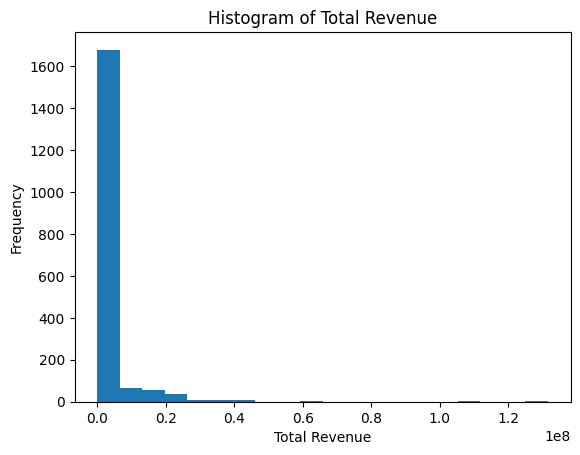

In [23]:
# Plot histogram for the Total_revenue

total_revenue_without_na = festivals_tot['Total_revenue'].dropna()

plt.hist(total_revenue_without_na, bins=20)
plt.xlabel('Total Revenue')
plt.ylabel('Frequency')
plt.title('Histogram of Total Revenue')
plt.show()

In [36]:
# Count the number of festivals per country
festivals_per_country = festivals_tot['Country'].value_counts()

# Print the first 10 entries in descending order
print(festivals_per_country.head(10))

LowerSaxony              431
Bavaria                  385
Northrhine-Westphalia    349
Baden-Württemberg        252
Hesse                    208
Austria                  194
Saxony-Anhalt            153
Brandenburg              151
Schleswig-Holstein       149
Saxony                   145
Name: Country, dtype: int64


In [37]:
# Filter festivals in Italy
italian_festivals = festivals_tot[festivals_tot['Country'] == 'Italy']

# Count the number of festivals in Italy
num_italian_festivals = italian_festivals.shape[0]

# Let´s prove that this dataset is not complete for each European country!
print("Number of festivals in Italy:", num_italian_festivals)

Number of festivals in Italy: 17


In [39]:
fest_final = pd.read_csv('festivals_tot.csv')

In [42]:
import folium
from folium.plugins import HeatMap

# Create a base map of Europe
m = folium.Map(location=[51.1657, 10.4515], zoom_start=5)

# Add a heatmap layer with festival counts per country
heat_data = []
for country, count in festivals_per_country.items():
    # Check if Latitude and Longitude columns exist
    if "Latitude" in fest_final.columns and "Longitude" in fest_final.columns:
        # Check if the country entry is a list of coordinates
        if isinstance(country, list):
            # Iterate over the coordinates and add non-NaN values to the heatmap data
            for coord in country:
                if not any(map(lambda x: pd.isnull(x), coord)):  # Check for NaN values
                    heat_data.append([coord[0], coord[1], count])  # Append latitude, longitude, count
        else:
            # Retrieve latitude and longitude corresponding to the country
            lat = fest_final.loc[fest_final['Country'] == country, 'Latitude'].iloc[0]
            lon = fest_final.loc[fest_final['Country'] == country, 'Longitude'].iloc[0]
            # Check if latitude and longitude are not NaN before adding to heatmap data
            if not (pd.isnull(lat) or pd.isnull(lon)):
                heat_data.append([lat, lon, count])  # Append latitude, longitude, count
    else:
        # Add country name as the tooltip for the heatmap
        heat_data.append([country, count])

# Add heatmap layer to the map
HeatMap(heat_data, min_opacity=0.5, max_zoom=18, radius=15, blur=10).add_to(m)

# Display the map
m